In [ ]:
%load_ext autoreload
%autoreload 2

In [28]:
import librosa
from matplotlib import pyplot as plt
from IPython import display as ipd
import numpy as np

# Analisis temporal

In [14]:
audio, sr = librosa.load('../kaggle-birds/dataset/wavs_32k/aldfly/XC134874.wav', sr=32000)

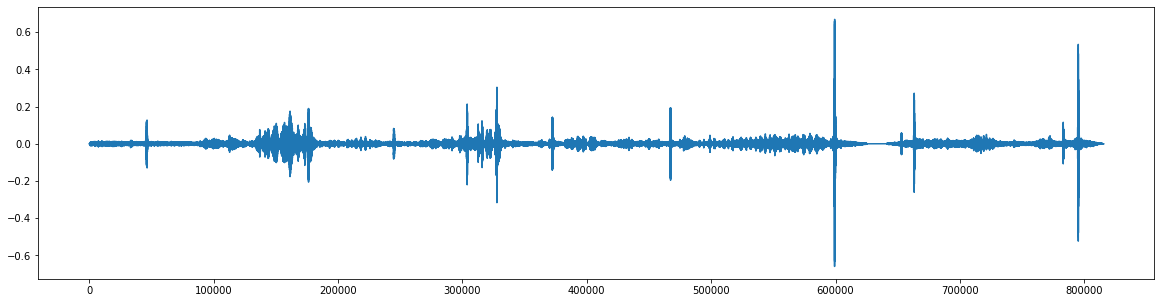

In [15]:
plt.figure(figsize=(20,5))
plt.plot(audio)

In [16]:
ipd.Audio(audio, rate=sr)

In [18]:
audio.std(), audio.mean()

(0.016606256, -1.600379e-05)

# Analisis en Frecuencia

In [55]:
stft = librosa.stft(audio, n_fft=2048, hop_length=128, win_length=2048, window='hann')

In [56]:
stft.shape

(1025, 6373)

In [57]:
# Es un valor complejo
stft[10, 10]

(-0.0025688796+0.0016289776j)

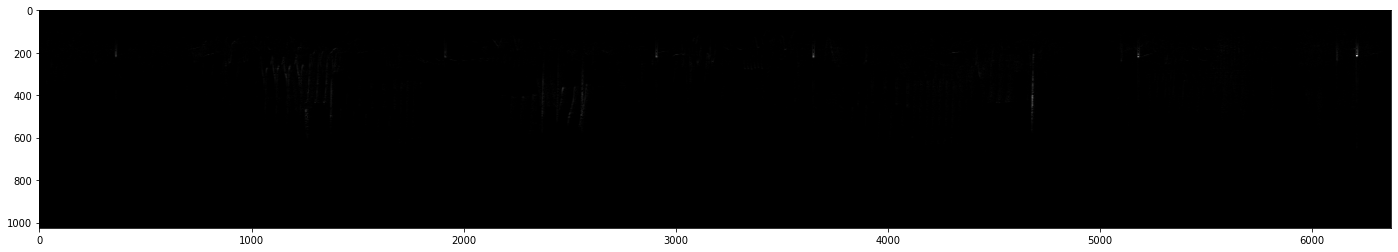

In [58]:
plt.figure(figsize=(30,4))
plt.imshow(np.abs(stft), cmap='gray')

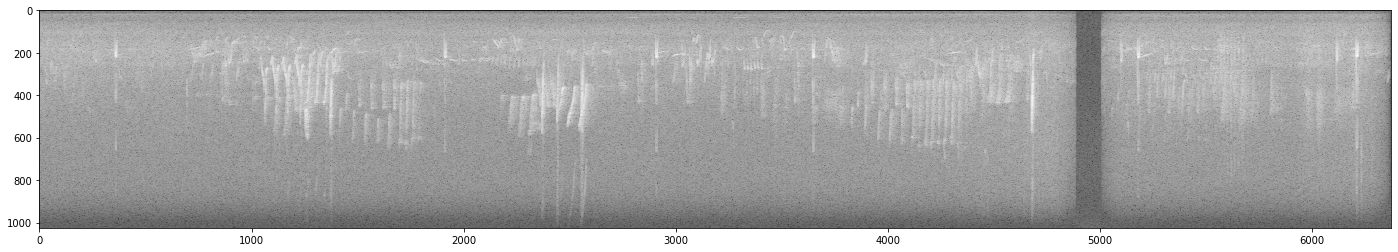

In [90]:
plt.figure(figsize=(30,4))
plt.imshow(20*np.log(np.abs(stft)), cmap='gray')

In [60]:
ipd.Audio(audio, rate=sr)

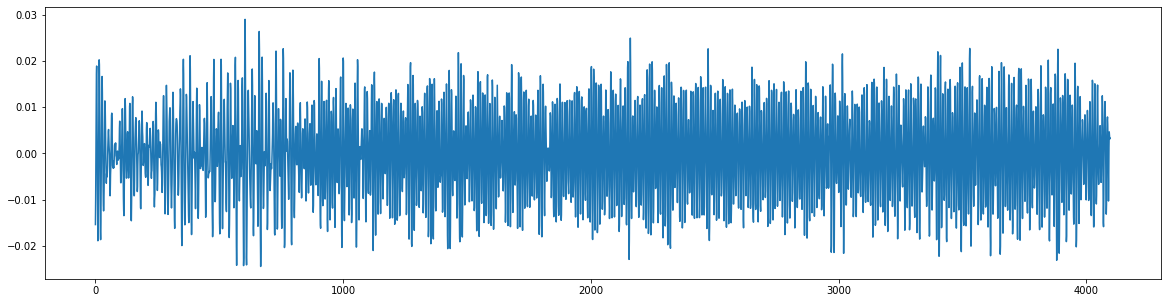

In [63]:
plt.figure(figsize=(20,5))
plt.plot(audio[100000:104096])

# Resolver el problema con Red Neuronal

In [85]:
def get_fourier_weights_for_mel(window_size, hanning=True):
    frec = np.linspace(-window_size//2, 0, window_size//2+1)
    time = np.linspace(0, window_size-1, window_size)
    
    if hanning:
        hanning_window = np.hanning(window_size)

    filters_cos = []
    filters_sin = []
    for f in frec:
        filters_cos.append(np.cos(2*np.pi*f*time/window_size))
        filters_sin.append(np.sin(2*np.pi*f*time/window_size))
        
    if hanning:
        filters_cos = np.array(filters_cos)[::-1]*hanning_window
        filters_sin = np.array(filters_sin)[::-1]*hanning_window
    else:
        filters_cos = np.array(filters_cos)[::-1]
        filters_sin = np.array(filters_sin)[::-1]
    return filters_cos, filters_sin

In [86]:
filters_cos, filters_sin = get_fourier_weights_for_mel(2048, hanning=False)

In [87]:
filters_cos.shape

(1025, 2048)

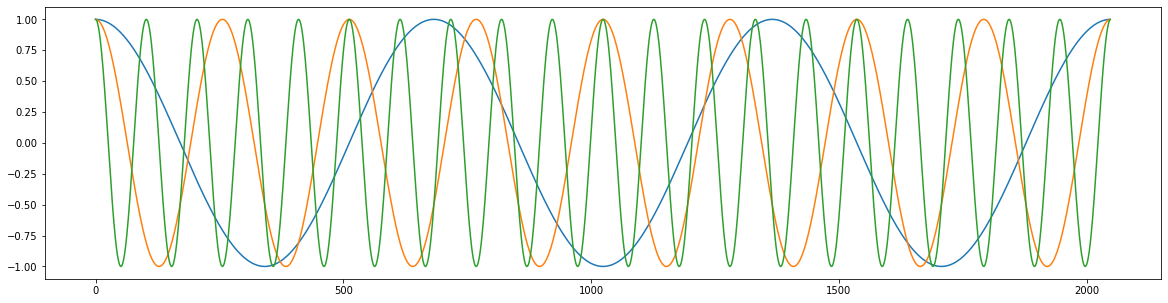

In [88]:
plt.figure(figsize=(20,5))
for i in [3, 8, 20]:
    plt.plot(filters_cos[i,:])

In [89]:
import torch

In [193]:
class STFTModel(torch.nn.Module):
    def __init__(self, window_size = 2048, train_fourier=False, sr=22050, hop_size=128):
        super().__init__()
        
        kernel_size = window_size
        stride = hop_size
        filters = kernel_size//2 + 1
        
        self.cos = torch.nn.Conv1d(in_channels=1, out_channels=filters, kernel_size=kernel_size, stride=stride, bias=False)
        self.sin = torch.nn.Conv1d(in_channels=1, out_channels=filters, kernel_size=kernel_size, stride=stride, bias=False)

        cos_weights, sin_weights = get_fourier_weights_for_mel(window_size)
        self.cos.weight.data = torch.from_numpy(cos_weights.reshape(cos_weights.shape[0], 1, cos_weights.shape[1])).float()
        self.sin.weight.data = torch.from_numpy(sin_weights.reshape(sin_weights.shape[0], 1, sin_weights.shape[1])).float()
            
        list(self.cos.parameters())[0].requires_grad = train_fourier
        list(self.sin.parameters())[0].requires_grad = train_fourier

    def forward(self, x):
        stft = self.cos(x)**2 + self.sin(x)**2
        x_spec = 10.0 * torch.log10(stft)
        return x_spec

In [194]:
model = STFTModel()

In [195]:
audio.shape

(815616,)

In [206]:
model.eval()
stft_model_out = model(torch.from_numpy(audio.reshape(1,1,-1)))

In [207]:
stft_model_out.shape

torch.Size([1, 1025, 6357])

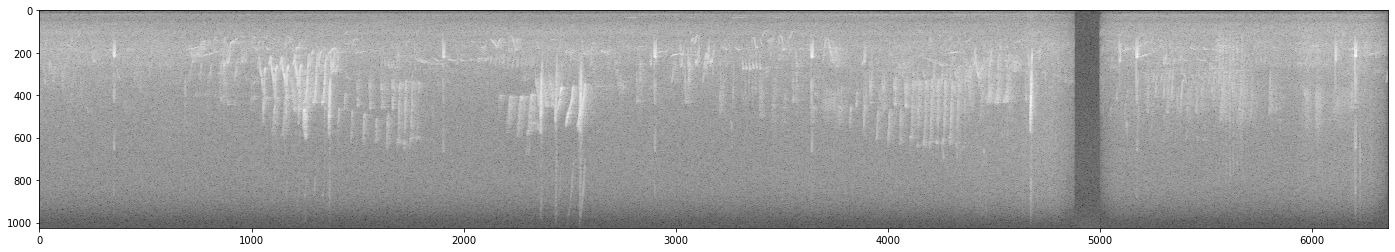

In [208]:
plt.figure(figsize=(30,4))
plt.imshow(stft_model_out.squeeze(0), cmap='gray')

# MFCC

In [199]:
mel_filters = librosa.filters.mel(sr, n_fft=2048, n_mels=128, fmin=0, fmax=sr/2)

In [200]:
mel_filters.shape

(128, 1025)

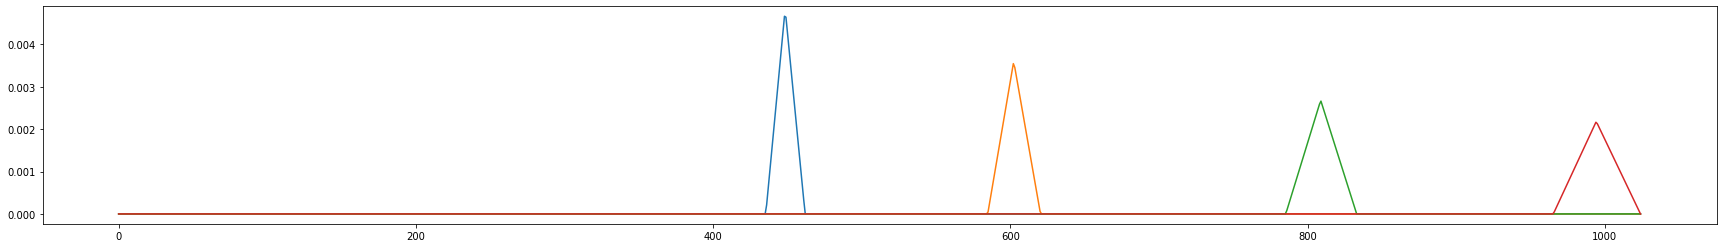

In [201]:
plt.figure(figsize=(30,4))
plt.plot(mel_filters[100,:])
plt.plot(mel_filters[110,:])
plt.plot(mel_filters[120,:])
plt.plot(mel_filters[127,:])

In [245]:
class MelSpectrogramModel(torch.nn.Module):
    def __init__(self, window_size = 2048, train_fourier=False, sr=22050, hop_size=128, n_mels=128, train_mel=False, fmin=0, fmax=None, in_db=False):
        super().__init__()
        self.in_db = in_db
        kernel_size = window_size
        stride = hop_size
        filters = kernel_size//2 + 1
        
        # STFT
        self.cos = torch.nn.Conv1d(1, filters, kernel_size, stride=stride, bias=False)
        self.sin = torch.nn.Conv1d(1, filters, kernel_size, stride=stride, bias=False)

        cos_weights, sin_weights = get_fourier_weights_for_mel(window_size)
        self.cos.weight.data = torch.from_numpy(cos_weights.reshape(cos_weights.shape[0], 1, cos_weights.shape[1])).float()
        self.sin.weight.data = torch.from_numpy(sin_weights.reshape(sin_weights.shape[0], 1, sin_weights.shape[1])).float()
        
        # No entrenables
        list(self.cos.parameters())[0].requires_grad = train_fourier
        list(self.sin.parameters())[0].requires_grad = train_fourier
        
        # MEL
        mel_filters = librosa.filters.mel(sr, n_fft=window_size, n_mels=n_mels, fmin=fmin, fmax=fmax)
        self.mel_filter = torch.nn.Conv1d(in_channels=mel_filters.shape[1], out_channels=mel_filters.shape[0], kernel_size=1, bias=False)
        self.mel_filter.weight.data[:,:,0] = torch.from_numpy(mel_filters)
        
        # No entrenable
        list(self.mel_filter.parameters())[0].requires_grad = train_mel

    def forward(self, x):
        stft = self.cos(x)**2 + self.sin(x)**2
        mel_out = self.mel_filter(stft)
        if self.in_db:
            mel_out_db = 10.0 * torch.log10(mel_out)
            return mel_out_db
        else:
            return mel_out

In [246]:
# Analizar en vez del logaritmo, usar exponente entre 0 y 1
mel_model = MelSpectrogramModel(in_db=False)

In [247]:
mel_model_out = mel_model(torch.from_numpy(audio.reshape(1,1,-1)))

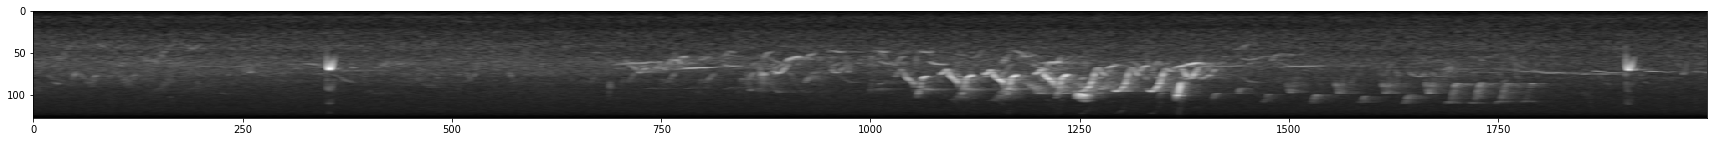

In [248]:
plt.figure(figsize=(30,4))
plt.imshow((mel_model_out.squeeze(0)[:,0:2000])**(1/8), cmap='gray')

In [249]:
torch.sigmoid(torch.from_numpy(np.array([-1.6])))

tensor([0.1680], dtype=torch.float64)